In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

## Load data

In [2]:
from data.config import DataConfig
from data.prep import DataPreprocessor

data_config = DataConfig(run_type='custom_test')
dp = DataPreprocessor(package='fault_detection')

data_loader, _ = dp.get_custom_data_package(data_config)

'fs' is updated in data_config as given in loaded healthy (or unknown) data.
New fs:
[[2499.5852, 2499.5852, 2499.5852],
 [9986.438 , 9986.438 , 9986.438 ]]


Node and signal types are set as follows:

(<node_num>) <node_type> : [<signal_types>]
---------------------------------------------
(1) 2_ammf   : [acc_x, acc_y, acc_z]
(2) 3_lra   : [pos_x, pos_y, pos_z]


Total samples: 13, 
Desired samples: 13 [OK=13, NOK=0, UK=0], 
Remainder samples: 0 [OK=0, NOK=0, UK=0]


In [3]:
dataiter = iter(data_loader)
data, labels = next(dataiter)

In [4]:
data.shape, labels.shape

(torch.Size([10, 2, 4000, 3]), torch.Size([10, 1]))

### Freq domain

In [5]:
from data.transform import DomainTransformer
from data.config import get_domain_config

domain_config = get_domain_config('freq', data_config=data_config)

domain_transformer = DomainTransformer(domain_config)
freq_mag, freq_bins = domain_transformer.transform(data)

## Feature extraction

In [6]:
from settings.manager import get_feature_list

feat_list = get_feature_list(n=7, perf_v=1, rank_v='[a=0.5]', domain='freq', data_config=data_config)
feat_list

FileNotFoundError: Performance log path c:\AFD_thesis\feature_extraction\logs\asml\NXE\full_wafer\(2_ammf+3_lra)\(2_ammf+3_lra)_perf_1 does not exist. Please run the feature performance ranking first or type the correct version.

In [7]:
from extractor import TimeFeatureExtractor
from feature_extraction.settings.feature_config import get_time_feat_config

feat_configs = [
    get_time_feat_config(feat_type='from_ranks', n=5, perf_v=1, rank_v='[a=0.5]', data_config=data_config),
    {'type': 'hist_lower_bound'}
]

time_fex = TimeFeatureExtractor(feat_configs)
time_features = time_fex.extract(data)

In [8]:
time_features.shape

torch.Size([50, 1, 6, 1])

In [7]:
from extractor import FrequencyFeatureExtractor
from feature_extraction.settings.feature_config import get_freq_feat_config

feat_configs = [
    # get_freq_feat_config(feat_type='first_n_modes', n_modes=7),
    get_freq_feat_config(feat_type='full_spectrum', data_config=data_config, parameters=['freq', 'psd']),
]

freq_fex = FrequencyFeatureExtractor(feat_configs)
freq_features = freq_fex.extract(freq_mag, freq_bins)

In [8]:
freq_features.shape

torch.Size([10, 2, 4000, 3])

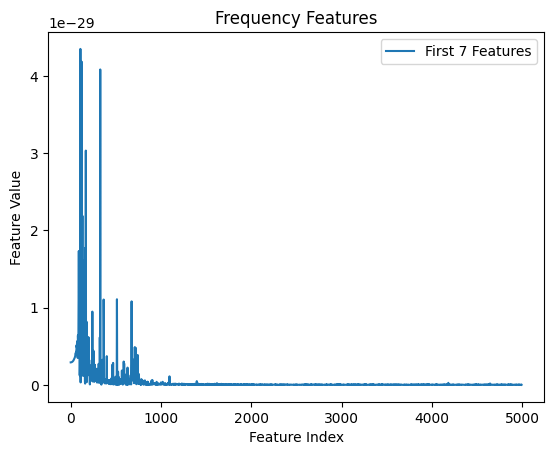

In [10]:
import matplotlib.pyplot as plt

# Plot the first 7 frequency features
plt.plot(freq_features[1, 1, :2000, 0].cpu().numpy(), freq_features[1, 1, 2000:4000, 0].cpu().numpy(),  label='First 7 Features')

plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('Frequency Features')
plt.legend()
plt.show()